## Business Problem

To identify whether a telecom network is under attack or not based on the network logs.

## Importing the packages

In [ ]:
# Uploading files to colab

#from google.colab import files
#files.upload()

In [ ]:
import pandas as pd                                                       # Pandas package for reading csv files
import numpy as np                                                        # Numpy package for computing
import matplotlib.pyplot as plt                                           # Visualization package

%matplotlib inline

In [ ]:
import seaborn as sns                                                    # Visualization package
import dask.dataframe as dd                                               # Dask to read dataframe


In [ ]:
# Installing necessary packages

!pip -q install shap
!pip -q install lime
!pip -q install eli5

### Reading the data with Pandas

In [ ]:
%time                                                           # Check the time to run a particular cell
train = pd.read_csv('new_train.csv')                             # Reading data using simple Pandas

### Reading the data with Dask

In [ ]:
%time                                                           # Check the time to read a particular cell
dask_train = dd.read_csv('new_train.csv')                        # Reading data using dask

For now we will continue to work with our pandas dataframe.

In [25]:
print(train.shape)                                                # Checking the number of rows and columns in the dataframe

(82000, 43)


In [26]:
pd.set_option('display.max_columns', 50)                          # For displaying all the columns
train.head()

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,Num_failed_logins,Logged_in,Num_compromised,Root_shell,Su_attempted,Num_root,Num_file_creations,Num_shells,Num_access_files,Num_outbound_cmds,Is_hot_login,Is_guest_login,Count,Srv_count,Serror_rate,Srv_serror_rate,Rerror_rate,Srv_rerror_rate,Same_srv_rate,Diff_srv_rate,Srv_diff_host_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,time,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,234,14,1.0,1.0,0.0,0.0,0.06,0.06,0.0,255,14,0.05,0.07,0.00,0.00,1.0,1.0,0.0,0.0,1.0,20
1,0,tcp,http,SF,241,12079,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.00,0.00,0.0,32,255,1.00,0.00,0.03,0.04,0.0,0.0,0.0,0.0,0.0,21
2,0,icmp,urp_i,SF,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,2,0.0,0.0,0.0,0.0,0.05,0.05,0.0,255,18,0.07,0.01,0.07,0.00,0.0,0.0,0.0,0.0,0.0,18
3,0,tcp,http,SF,229,309,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.00,0.00,0.0,58,255,1.00,0.00,0.02,0.01,0.0,0.0,0.0,0.0,0.0,21
4,0,tcp,ftp_data,SF,12165,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.00,0.00,0.0,143,44,0.27,0.03,0.27,0.05,0.0,0.0,0.0,0.0,0.0,21


In [27]:
# Lets have a look at the attack column which is the target column to be predicted

train.iloc[:,-2].value_counts()

0.0    67342
1.0    14658
Name: attack, dtype: int64

This is an imbalanced class classification

## Exploratory Data Analysis

In [30]:
# Using Pandas profiling package to perform EDA

import pandas_profiling

reports1=pandas_profiling.ProfileReport(train)

In [29]:
reports1.to_file('train_merge_EDA.html')                                   # Creating HTML file of pandas-profiling report

In this report we are able to see that there is strong correlation between a lot of columns.  <br>
If this were a regression problem these columns are bad and needed to be dropped. But this is a classification columns.

In [28]:
# Checking the data types and missing values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82000 entries, 0 to 81999
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Duration                     82000 non-null  int64  
 1   Protocol_type                82000 non-null  object 
 2   Service                      82000 non-null  object 
 3   Flag                         82000 non-null  object 
 4   Src_bytes                    82000 non-null  int64  
 5   Dst_bytes                    82000 non-null  int64  
 6   Land                         82000 non-null  int64  
 7   Wrong_fragment               82000 non-null  int64  
 8   Urgent                       82000 non-null  int64  
 9   Hot                          82000 non-null  int64  
 10  Num_failed_logins            82000 non-null  int64  
 11  Logged_in                    82000 non-null  int64  
 12  Num_compromised              82000 non-null  int64  
 13  Root_shell      

**There are no null values.**

In [32]:
# Lets separate the categorical columns

cat_cols = ['Protocol_type','Service','Flag']

**Descriptive Analysis of the columns**

In [33]:
# These are important Insights 
If your DST & SRC Bytes are above 5000-7000 then, no Attack 
If Num_Com = 1, then attack 

SyntaxError: invalid syntax (<ipython-input-33-c1af80c2494b>, line 2)

In [ ]:
train[(train['Num_compromised'] < 1)]['attack'].value_counts()

In [ ]:
train.describe().T

There are 39 numeric columns. <br>
A lot of them are binary and a few have numeric values.  <br>
Lets have a look at their correlation plot. 

In [38]:
# Lets plot the correlation matrix 

corr_matrix = train.corr()
corr_matrix

,Duration,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,Num_failed_logins,Logged_in,Num_compromised,Root_shell,Su_attempted,Num_root,Num_file_creations,Num_shells,Num_access_files,Num_outbound_cmds,Is_hot_login,Is_guest_login,Count,Srv_count,Serror_rate,Srv_serror_rate,Rerror_rate,Srv_rerror_rate,Same_srv_rate,Diff_srv_rate,Srv_diff_host_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack,last_flag
Duration,1.000000,0.015477,0.077427,-0.001410,-0.006376,0.007207,0.004310,0.023874,-0.086462,0.076148,0.103768,0.155859,0.081181,0.176950,-0.001913,0.127336,NaN,-0.000297,-0.005410,-0.056181,-0.045141,-0.040904,-0.041176,0.138054,0.141844,0.020497,0.031456,-0.046641,0.057049,-0.162204,-0.173513,0.313536,0.232848,-0.024685,-0.025814,-0.026152,0.109148,0.139179,0.042065,-0.108761
Src_bytes,0.015477,1.000000,0.016087,-0.000389,-0.001744,-0.000273,0.000437,-0.000805,0.013972,-0.000381,-0.001066,-0.000853,-0.000423,-0.000503,-0.000449,-0.001366,NaN,-0.000106,-0.003086,-0.015488,-0.012135,-0.010178,-0.010031,-0.008593,-0.008513,0.012281,-0.002454,-0.007848,-0.008670,-0.032315,-0.026382,0.006399,0.017503,-0.002219,-0.009287,-0.010360,-0.008121,-0.008509,-0.006813,-0.027872
Dst_bytes,0.077427,0.016087,1.000000,-0.000077,-0.000350,0.000961,-0.000180,0.002594,-0.002726,0.004506,0.004536,0.004289,0.004501,0.000576,-0.000119,0.001622,NaN,-0.000002,-0.000474,-0.003011,-0.002252,-0.001856,-0.001862,0.011936,0.011887,0.002744,-0.001527,-0.001948,0.002521,-0.005415,-0.005982,0.009482,0.010621,-0.001190,-0.001571,-0.001401,0.012555,0.012308,0.006558,-0.020595
Land,-0.001410,-0.000389,-0.000077,1.000000,-0.000717,-0.000121,-0.001231,-0.000340,-0.015100,-0.000178,-0.000528,-0.000379,-0.000193,-0.000393,-0.000270,-0.000637,NaN,-0.000044,-0.001357,-0.005623,-0.004991,0.035068,0.035253,-0.003576,-0.003592,0.002788,-0.002809,0.038049,-0.019693,-0.018612,0.009375,-0.004559,0.039552,0.100947,0.035224,0.023066,-0.003786,-0.003672,0.009294,-0.066902
Wrong_fragment,-0.006376,-0.001744,-0.000350,-0.000717,1.000000,-0.000546,-0.005565,-0.001538,-0.068279,-0.000806,-0.002388,-0.001716,-0.000872,-0.001777,-0.001222,-0.002881,NaN,-0.000199,-0.006135,0.007660,0.017324,-0.007315,-0.021126,-0.015767,-0.016241,0.011972,-0.011081,-0.020824,0.037614,-0.056022,-0.061932,0.052901,0.026914,-0.012122,-0.016834,-0.020463,0.035126,-0.016603,0.122042,-0.139410
Urgent,0.007207,-0.000273,0.000961,-0.000121,-0.000546,1.000000,0.000293,0.118730,0.005211,0.033286,0.081388,0.097818,0.032422,0.025207,-0.000206,0.010682,NaN,-0.000033,-0.001033,-0.004929,-0.003938,-0.003593,-0.003558,-0.002723,-0.002735,0.004327,-0.002506,-0.004127,-0.006351,-0.014337,-0.010463,0.011813,0.004384,0.008595,-0.003268,-0.003446,-0.002883,-0.002796,0.002677,-0.027741
Hot,0.004310,0.000437,-0.000180,-0.001231,-0.005565,0.000293,1.000000,0.000808,0.080576,0.001990,0.011199,-0.000004,0.001571,0.030108,0.001487,-0.004321,NaN,0.001226,0.834501,-0.049983,-0.039756,-0.033769,-0.033702,-0.025012,-0.024416,0.037069,0.000130,-0.032466,-0.008890,-0.107435,-0.092578,0.011620,-0.032200,-0.027340,-0.033172,-0.032908,-0.022034,-0.023392,-0.012462,-0.086896
Num_failed_logins,0.023874,-0.000805,0.002594,-0.000340,-0.001538,0.118730,0.000808,1.000000,-0.009241,0.023242,0.043144,0.089284,0.022050,0.023366,-0.000580,0.000792,NaN,-0.000094,-0.000424,-0.013830,-0.011086,-0.006774,-0.008343,0.010930,0.010817,0.009457,0.001417,-0.011627,-0.011746,-0.035582,-0.027790,0.007478,-0.008184,-0.002316,-0.001428,-0.003068,0.005477,0.004794,-0.006382,-0.069527
Logged_in,-0.086462,0.013972,-0.002726,-0.015100,-0.068279,0.005211,0.080576,-0.009241,1.000000,0.011802,0.034976,0.025129,0.012770,0.026029,0.017893,0.042199,NaN,0.002912,0.088918,-0.523876,-0.324615,-0.398907,-0.399616,-0.319488,-0.314961,0.495974,-0.214206,0.120351,-0.321618,0.483689,0.468745

**Num_outbound_cmds** is empty column. We need to drop it.

**Let's check for any correlation in the data**

### Random 15 columns and make correlations

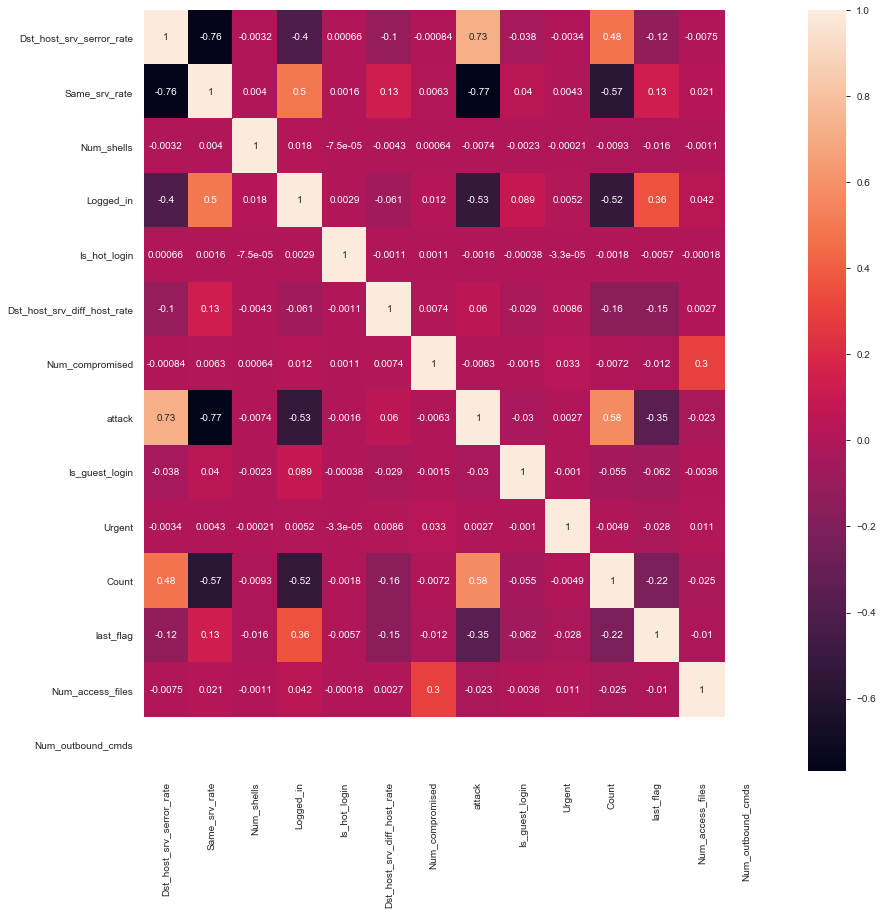

In [34]:
# Lets take random 15 columns and plot the correlation matrix

small_df = train.sample(15, axis=1)
small_corr_matrix = small_df.corr()

plt.figure(figsize=(14,14))
sns.heatmap(small_corr_matrix, annot=True)

### Lets look at some strong correlations.

In [36]:
col_names = train.columns                                         # Name of all the columns
col_names

Index(['Duration', 'Protocol_type', 'Service', 'Flag', 'Src_bytes',
       'Dst_bytes', 'Land', 'Wrong_fragment', 'Urgent', 'Hot',
       'Num_failed_logins', 'Logged_in', 'Num_compromised', 'Root_shell',
       'Su_attempted', 'Num_root', 'Num_file_creations', 'Num_shells',
       'Num_access_files', 'Num_outbound_cmds', 'Is_hot_login',
       'Is_guest_login', 'Count', 'Srv_count', 'Serror_rate',
       'Srv_serror_rate', 'Rerror_rate', 'Srv_rerror_rate', 'Same_srv_rate',
       'Diff_srv_rate', 'Srv_diff_host_rate', 'Dst_host_count',
       'Dst_host_srv_count', 'Dst_host_same_srv_rate',
       'Dst_host_diff_srv_rate', 'Dst_host_same_src_port_rate',
       'Dst_host_srv_diff_host_rate', 'Dst_host_serror_rate',
       'Dst_host_srv_serror_rate', 'Dst_host_rerror_rate',
       'Dst_host_srv_rerror_rate', 'attack', 'last_flag'],
      dtype='object')

In [39]:
# In this block of code we are going to check all the variables with correlation above a certain threshold

corr_threshold = 0.8                                                 # This is a correlation threshold. We need to find variables with greater threshold

print("---------------CHECKING FOR CORRELATION------------")
for c in col_names:
    for r in col_names:
        if (r < c):
            if (c not in cat_cols) and (c is not 'attack') and (r not in cat_cols) and (r is not 'attack') :
                if abs(corr_matrix[r][c]) > corr_threshold:
                    print(c +" : "+ r+" : "+ str(corr_matrix[r][c]))

---------------CHECKING FOR CORRELATION------------
Num_root : Num_compromised : 0.9988405913891037
Is_guest_login : Hot : 0.8345014435714884
Serror_rate : Dst_host_serror_rate : 0.9430935971904737
Serror_rate : Dst_host_srv_serror_rate : 0.9533227114963565
Srv_serror_rate : Serror_rate : 0.98806385257668
Srv_serror_rate : Dst_host_serror_rate : 0.9411508433197037
Srv_serror_rate : Dst_host_srv_serror_rate : 0.9621919153678669
Rerror_rate : Dst_host_rerror_rate : 0.9056647593100042
Rerror_rate : Dst_host_srv_rerror_rate : 0.9301657113713273
Srv_rerror_rate : Rerror_rate : 0.9859603717939368
Srv_rerror_rate : Dst_host_rerror_rate : 0.8956309277220983
Srv_rerror_rate : Dst_host_srv_rerror_rate : 0.933453707092518
Dst_host_srv_count : Dst_host_same_srv_rate : 0.8896811763354369
Dst_host_srv_serror_rate : Dst_host_serror_rate : 0.9657945117230091
Dst_host_srv_rerror_rate : Dst_host_rerror_rate : 0.9089000644659833


We have found the same insights as profiling report.  <br>  <br>

We are going to plot some of these correlations.

**Lets separate our attack and normal connections and store in a separate dataframe.**

In [40]:
y = train['attack']
y.unique()

array([1., 0.])

In [41]:
y.value_counts()

0.0    67342
1.0    14658
Name: attack, dtype: int64

## Plots

In [43]:
%matplotlib inline

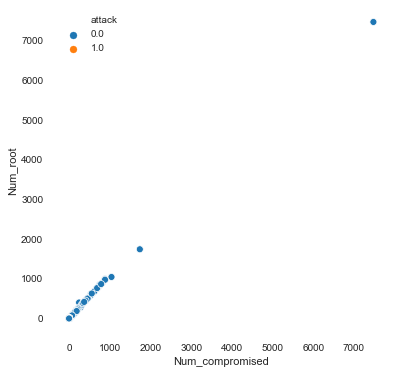

In [44]:
# Scatter plot of Num_compromised and Num_root 

plt.figure(figsize=(6,6))
sns.scatterplot('Num_compromised','Num_root', data=train, hue=y)

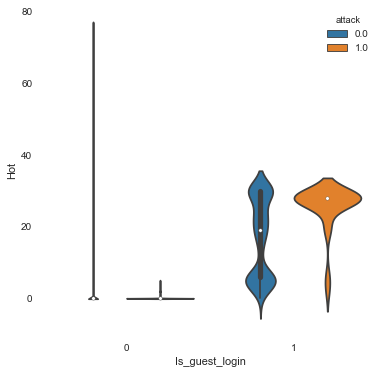

In [45]:
# Violin plot of Is_guest_login and Hot

plt.figure(figsize=(6,6))
sns.violinplot('Is_guest_login', 'Hot', data=train, hue=y)

**Observation**: There are very few logins which are not guest.<br>
There are **guest logins** where **hot operations** are between 0-10 and 25-35 **are actually attack connections**.

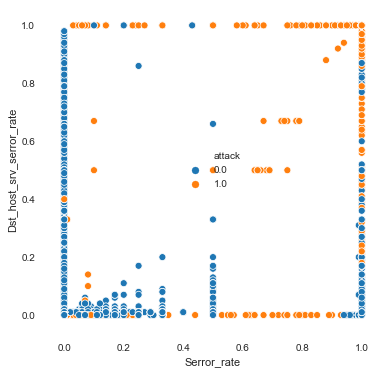

In [46]:
# Scatter plot of Serror_rate and Dst_host_srv_serror_rate 

plt.figure(figsize=(6,6))
sns.scatterplot('Serror_rate', 'Dst_host_srv_serror_rate', data=train, hue=y)    

**Observation**: There are a lot of attacks happening.

In [47]:
np.unique(y[train['Serror_rate'] > 0.5], return_counts=True)

(array([0., 1.]), array([ 437, 8788], dtype=int64))

**Observation** : There are 8788 attacks when Serror_rate is greater than 0.5

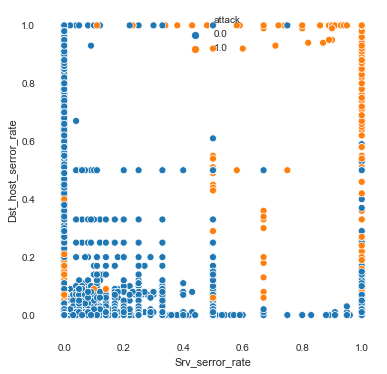

In [48]:
# Scatter plot of Srv_serror_rate and Dst_host_serror_rate

plt.figure(figsize=(6,6))
sns.scatterplot('Srv_serror_rate', 'Dst_host_serror_rate', data=train, hue=y)    

**Observation**: **Srv_serror_rate** and **Dst_host_serror_rate** are clear indicators of attacks happening or not.  <br>
Basically if I draw a diagonal line, it will separate most of the attacks. <br>
Equation of the classification line will be **Srv_serror_rate** + **Dst_host_serror_rate** = 1

In [49]:
np.unique(y[(train['Srv_serror_rate'] + train['Dst_host_serror_rate']) > 1], return_counts=True)

(array([0., 1.]), array([ 311, 8786], dtype=int64))

**Observation** : 8786 attacks and 311 normal conditions when Srv_serror_rate + Dst_host_serror_rate greater than 1.

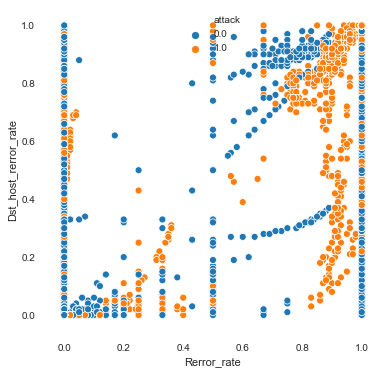

In [50]:
# Scatter plot of Rerror_rate and Dst_host_rerror_rate  

plt.figure(figsize=(6,6))
sns.scatterplot('Rerror_rate', 'Dst_host_rerror_rate', data=train, hue=y)    

**Observation**: Lots of attacks when **rerror_rate** greater than 0.5

In [ ]:
y[train['Rerror_rate'] > 0.5].value_counts()
#np.unique(y[train['Rerror_rate'] > 0.5], return_counts=True)

**Observation** : 3015 attacks and 2948 non attacks when rerror_rate greater than 0.5

Now we have done correlation plots and simple multivariate analysis to classify connections which are attack or normal.
Lets try to do this with machine learning algorithms.

# Handling Categorical Variables

In [51]:
# Lets one hot encode all the categorical columns

encoded_cols = pd.get_dummies(train[cat_cols], drop_first=True)
encoded_cols.shape

(82000, 79)

In [52]:
# We will concat the one hot encoded dataframe with train dataframe

train = pd.concat([train, encoded_cols], axis=1)
train.shape

(82000, 122)

# Creating Features and Labels

In [54]:
# Lets drop the categorical column as we have already included one hot columns

X = train.drop(cat_cols, axis = 1)

# We will also drop the target column "attack" and "Num_outbound_cmds"
X = X.drop(['attack', 'Num_outbound_cmds'], axis = 1)

In [55]:
X.shape                                                         # The number of rows and columns in the features

(82000, 117)

In [57]:
y = train['attack']                                              # The target label
y.unique()

array([1., 0.])

In [58]:
# Lets create our train and validation split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [59]:
# metrics

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, recall_score

In [60]:
def model_train(model, name):
    model.fit(X_train, y_train)                                          # Fitting the model
    y_pred = model.predict(X_test)                                       # Making prediction from the trained model
    cm = confusion_matrix(y_test, y_pred)                               
    print("Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
    print(cm)
    print('-----------------------')
    print('-----------------------')
    cr = classification_report(y_test, y_pred)
    print(name +" Classification Report " +" Validation Data")           # Displaying the Classification Report
    print(cr)
    print('------------------------')
    print(name +" AUC Score " +" Validation Data")
    auc = roc_auc_score(y_test, y_pred)       
    print("AUC Score " + str(auc))                                       # Displaying the AUC score
    print(name +" Recall " +" Validation Data")
    rec = recall_score(y_test, y_pred)
    print("Recall "+ str(rec))                                           # Displaying the Recall score
    print('_________________________')
    print(name + " Bias")                                                 # Calculating bias
    bias = y_pred - y_test.mean()
    print("Bias "+ str(bias.mean()))
    
    print(name + " Variance")                                             # Calculate Variance
    var = np.var([y_test, y_pred], axis=0)
    print("Variance " + str(var.mean()) )
    return auc, rec, model



# Model Building

## Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)

In [62]:
lr_auc, lr_rec, lr_model = model_train(lr, "Logistic Regression")

Grid Search Confusion Matrix  Validation Data
[[12922   506]
 [  697  2275]]
-----------------------
-----------------------
Logistic Regression Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     13428
         1.0       0.82      0.77      0.79      2972

    accuracy                           0.93     16400
   macro avg       0.88      0.86      0.87     16400
weighted avg       0.93      0.93      0.93     16400

------------------------
Logistic Regression AUC Score  Validation Data
AUC Score 0.8638976690798159
Logistic Regression Recall  Validation Data
Recall 0.7654777927321669
_________________________
Logistic Regression Bias
Bias -0.011646341463414598
Logistic Regression Variance
Variance 0.01833841463414634


Model is not so great with a lot of FN (False Negetive)

## Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, min_samples_leaf =3, random_state=101)

In [65]:
dt_auc, dt_rec, dt_model = model_train(dt, "Decision Tree")

Grid Search Confusion Matrix  Validation Data
[[13422     6]
 [    6  2966]]
-----------------------
-----------------------
Decision Tree Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13428
         1.0       1.00      1.00      1.00      2972

    accuracy                           1.00     16400
   macro avg       1.00      1.00      1.00     16400
weighted avg       1.00      1.00      1.00     16400

------------------------
Decision Tree AUC Score  Validation Data
AUC Score 0.998767164972571
Decision Tree Recall  Validation Data
Recall 0.9979811574697174
_________________________
Decision Tree Bias
Bias 3.528342929479461e-17
Decision Tree Variance
Variance 0.00018292682926829268


**The metric of our choice should be Recall as we want to minimize FN, which means that an attack accured but the model did not detect it.**

## Random Forest Algorithm

In [66]:
# Random Forest Algorithm

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
rf_auc, rf_rec, rf_model = model_train(rf_clf, "Random Forest Classifier")

Grid Search Confusion Matrix  Validation Data
[[13425     3]
 [    4  2968]]
-----------------------
-----------------------
Random Forest Classifier Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13428
         1.0       1.00      1.00      1.00      2972

    accuracy                           1.00     16400
   macro avg       1.00      1.00      1.00     16400
weighted avg       1.00      1.00      1.00     16400

------------------------
Random Forest Classifier AUC Score  Validation Data
AUC Score 0.999215345608762
Random Forest Classifier Recall  Validation Data
Recall 0.9986541049798116
_________________________
Random Forest Classifier Bias
Bias -6.097560975606206e-05
Random Forest Classifier Variance
Variance 0.00010670731707317073


## Grid Search

In [68]:
from sklearn.model_selection import GridSearchCV

random_grid = {'n_estimators': range(5,20),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [10,20,30,40],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_gs.fit(X_train, y_train)
y_pred = rf_gs.predict(X_test)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  7.2min finished


In [69]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:

print("Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Grid Search Validation Data
Grid Search Confusion Matrix  Validation Data
[[13425     3]
 [    5  2967]]
-----------------------
Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13428
         1.0       1.00      1.00      1.00      2972

    accuracy                           1.00     16400
   macro avg       1.00      1.00      1.00     16400
weighted avg       1.00      1.00      1.00     16400

------------------------
Grid Search AUC Score  Validation Data
AUC Score 0.9990471087312385
Grid Search Recall  Validation Data
Recall 0.9983176312247645
_________________________
Grid Search Bias
Bias -0.00012195121951215963
Grid Search Variance
Variance 0.00012195121951219512


## Randomized Grid Search

In [73]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    3.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


In [74]:

print("Randomized Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Randomized Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Randomized Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Randomized Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Randomized Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Randomized Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Randomized Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Randomized Grid Search Validation Data
Randomized Grid Search Confusion Matrix  Validation Data
[[13427     1]
 [    6  2966]]
-----------------------
Randomized Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13428
         1.0       1.00      1.00      1.00      2972

    accuracy                           1.00     16400
   macro avg       1.00      1.00      1.00     16400
weighted avg       1.00      1.00      1.00     16400

------------------------
Randomized Grid Search AUC Score  Validation Data
AUC Score 0.9989533431078108
Randomized Grid Search Recall  Validation Data
Recall 0.9979811574697174
_________________________
Randomized Grid Search Bias
Bias -0.0003048780487804521
Randomized Grid Search Variance
Variance 0.00010670731707317073


In [75]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Model Explainations

### Permutation Importance

We will run the permutation importance using Decision Tree Classifier

In [76]:
import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(dt_model, random_state=101).fit(X_test, y_test)      # Evaluate the permutation importance 
eli5.show_weights(perm, feature_names = X_test.columns.values)                    # Display the weights of each features

Using TensorFlow backend.


Weight,Feature
0.1449 ± 0.0025,Src_bytes
0.0295 ± 0.0007,last_flag
0.0132 ± 0.0008,Protocol_type_tcp
0.0121 ± 0.0006,Service_ecr_i
0.0113 ± 0.0008,Same_srv_rate
0.0065 ± 0.0004,Dst_host_srv_count
0.0064 ± 0.0006,Dst_host_same_srv_rate
0.0053 ± 0.0005,Dst_host_serror_rate
0.0032 ± 0.0008,Service_private
0.0032 ± 0.0006,Dst_host_srv_serror_rate


Lets check the same with Random Forest classifier

In [77]:
perm = PermutationImportance(rf_model, random_state=101).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.values)

Weight,Feature
0.0059 ± 0.0005,Src_bytes
0.0044 ± 0.0000,Service_eco_i
0.0034 ± 0.0002,last_flag
0.0023 ± 0.0005,Dst_bytes
0.0018 ± 0.0004,Dst_host_count
0.0017 ± 0.0001,Service_ecr_i
0.0011 ± 0.0002,Dst_host_same_src_port_rate
0.0010 ± 0.0003,Protocol_type_tcp
0.0006 ± 0.0003,Dst_host_srv_diff_host_rate
0.0005 ± 0.0000,Hot


**Conclusion**: The columns in the green are the most important features.

### Shap

Lets see how the columns impact a single record of data

In [78]:
row_to_show = 7                                                                # The row for which we want to check the SHAP explanations
data_to_predict = X_test.iloc[row_to_show]
#data_to_predict

In [79]:
data_to_preddict_array = data_to_predict.values.reshape(1,-1)

dt_model.predict_proba(data_to_preddict_array)                                 # Prediction probability on the row of the data

array([[0., 1.]])

In [80]:
dt_model.predict(data_to_preddict_array)                                       # Predicted output

array([1.])

In [81]:
y_test.iloc[row_to_show]

1.0

In [82]:
import shap

# Object that can calculate Shap values
explainer = shap.TreeExplainer(dt_model)                                       # SHAP Tree Explainer

# Calculate the shap values
shap_values = explainer.shap_values(data_to_predict)                           # SHAP explanations

In [83]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_to_predict)

### LIME

In [86]:
import lime
import lime.lime_tabular

In [87]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                         feature_names=X_train.columns.values.tolist(),
                                                         mode='classification',class_names='Attack')


In [89]:
lime_expln1=explainer.explain_instance(X_test.iloc[1],dt_model.predict_proba,num_features=X_test.shape[1], top_labels = 1)
lime_expln1.show_in_notebook(show_table=True, show_all=False)